In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [1]:
import sys
sys.path.append('/home/ec2-user/SageMaker/project-delta')
from ttd.models import BaseModel, ESMEncoder, ProteinDataset
from ttd.datasets import load_dataset_eskape, stratified_split

In [ ]:
df = load_dataset_eskape(by = "traits_of_interest",   class_size = 500, random_state = 42)

In [11]:
#df.to_csv("eskape_dataset_sample.csv", index=False)
df.to_csv("interest_1000__eskape_dataset_sample.csv", index=False)

In [71]:
import pickle

#df = pd.read_csv("eskape_dataset_sample.csv")
#df = pd.read_csv("small_eskape_dataset_sample.csv")
df = pd.read_csv("interest_1000__eskape_dataset_sample.csv")
label_to_hr = df.drop_duplicates("Label")[["Label", "HR_Label"]].set_index("Label")["HR_Label"].to_dict()
# Save
with open("label_to_hr.pkl", "wb") as f:
    pickle.dump(label_to_hr, f)
df.head()

,Sequence ID,Label,Sequence,Host,HR_Label
0,MF001361_00108,2,MTRFYKGIAGRRGANPSGVVIHNDAGSVYANAAFYRGWLPSHDAEN...,Enterococcus,endolysin
1,PP337149_00270,12,MEMEPTIDPSKESDHPIGLMHPKYLKKKIDELGMEWTQSEHDKKWY...,Enterobacter,terminase large subunit
2,JN986846_00169,13,MEGLDINKLLDISDLPGIDGEEIKVYEPLQLVEVKSNPQNRTPDLE...,Escherichia,terminase small subunit
3,MN066127_00072,11,MTGVQFKNENPNFAASDKWRLTIGDLVLLTRSIHDFSIPGVYSEGI...,Salmonella,tail tube
4,PP968062_00256,4,MKFEKLPSAKFRVTISFEEMRQRMVEGLRRDMAQLGKGRVEAVVEH...,Pseudomonas,head maturation protease


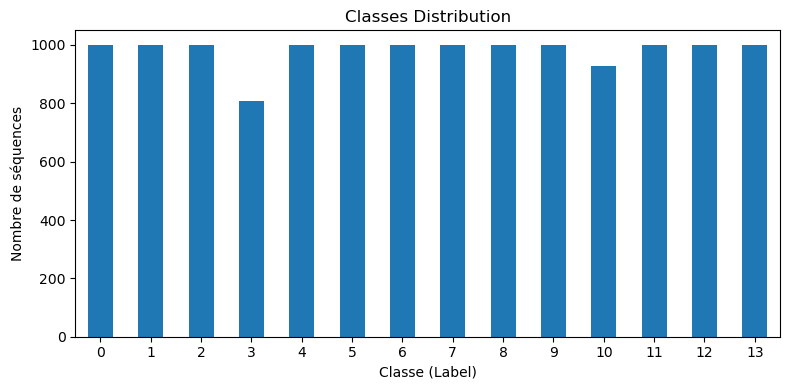

In [23]:
import matplotlib.pyplot as plt

# Tracer l'histogramme de la colonne 'Label'
plt.figure(figsize=(8, 4))
df["Label"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("Classe (Label)")
plt.ylabel("Nombre de séquences")
plt.title("Classes Distribution")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from esm.sdk.api import ESMProtein
from esm.models.esmc import ESMC
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Build proteins and labels from DataFrame
proteins = [ESMProtein(sequence=row["Sequence"]) for _, row in df.iterrows()]
labels = torch.tensor([row["Label"] for _, row in df.iterrows()])

# Split into train and test sets (e.g., 80/20 split)
proteins_train, proteins_test, labels_train, labels_test = stratified_split(proteins, labels, test_ratio=0.2, seed=42)


# Create Datasets
train_dataset = ProteinDataset(proteins_train, labels_train)
test_dataset = ProteinDataset(proteins_test, labels_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x[0])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x[0])

Device: cuda


In [18]:
client = ESMC.from_pretrained("esmc_300m").to("cuda") # or "cpu"
encoder = ESMEncoder(client, output="sequence")
# Freeze encoder weights
for param in encoder.parameters():
    param.requires_grad = False

hidden_dim = 960
num_classes = 14
basic_classifier = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
).to("cuda")

base_model = BaseModel(encoder, basic_classifier).to(device)

In [68]:
# CELL IF YOU WANT TO LOAD AN ALREADY EXISTING MODEL
# Rebuild the architecture first
client = ESMC.from_pretrained("esmc_300m").to(device)
encoder = ESMEncoder(client, output="sequence")

hidden_dim = 960
num_classes = 14
basic_classifier = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
).to(device)

base_model = BaseModel(encoder, basic_classifier).to(device)
base_model.load_state_dict(torch.load("base_model_final_14.pt"))
#model_loaded.eval()

<All keys matched successfully>

In [69]:
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

optimizer = torch.optim.Adam(base_model.classifier.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

entropy_per_epoch = []
loss_per_epoch = []
test_accuracy = []

# Training loop

for epoch in range(1):
    entropies = []
    base_model.train()
    total_loss = 0
    start_time = time.time()

    # Use tqdm to show progress in the current epoch
    for protein, label in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
        optimizer.zero_grad()

        logits = base_model(protein)  # base_model handles encoding
        label = torch.tensor([label]).to(device)

        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred_class, probs, entropy = base_model.predict(protein)
        entropies += entropy.tolist()

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}, Time: {epoch_time:.2f}s")
    loss_per_epoch.append(total_loss)
    print(f"Mean Entropy {np.mean(entropies)}")
    entropy_per_epoch.append(np.mean(entropies))
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for protein, label in test_loader:
            pred_class, probs, entropy = base_model.predict(protein)
            all_preds.append(pred_class.tolist())
            all_labels.append(label.tolist())
    acc = accuracy_score(all_labels, all_preds)
    test_accuracy.append(acc)
    print(f"Evaluation Accuracy: {acc:.4f}")

Epoch 1, Loss: 201.7539, Time: 17.09s
Mean Entropy 0.027619390543572354
Evaluation Accuracy: 0.9876


In [20]:
# SAVE MODEL
#torch.save(base_model.state_dict(), "base_model_final_14.pt")

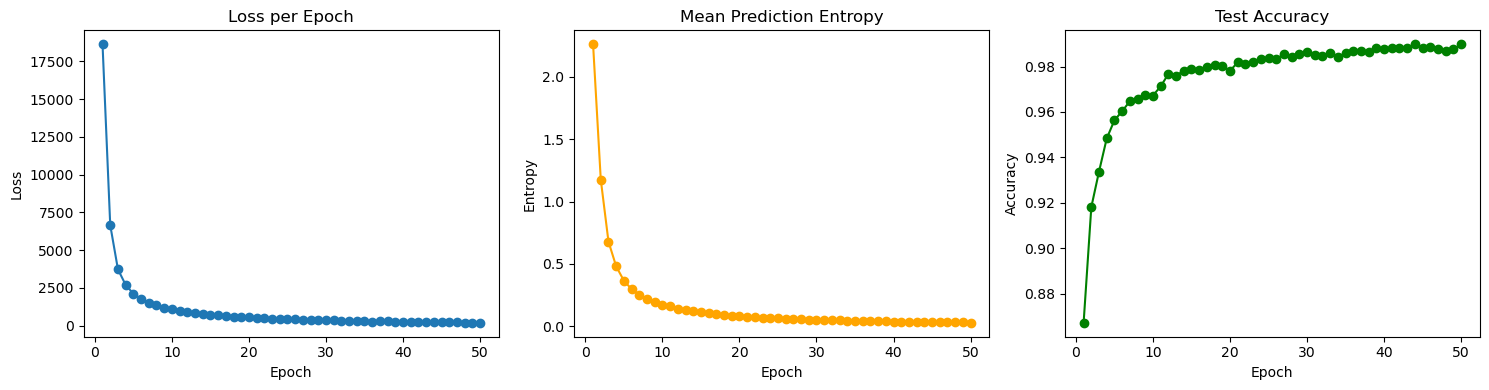

In [22]:
import matplotlib.pyplot as plt

def plot_training_metrics(loss_per_epoch, entropy_per_epoch, test_accuracy):
    epochs = list(range(1, len(loss_per_epoch) + 1))

    plt.figure(figsize=(15, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss_per_epoch, marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Entropy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, entropy_per_epoch, marker='o', color='orange')
    plt.title("Mean Prediction Entropy")
    plt.xlabel("Epoch")
    plt.ylabel("Entropy")

    # Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, test_accuracy, marker='o', color='green')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

plot_training_metrics(loss_per_epoch, entropy_per_epoch, test_accuracy)

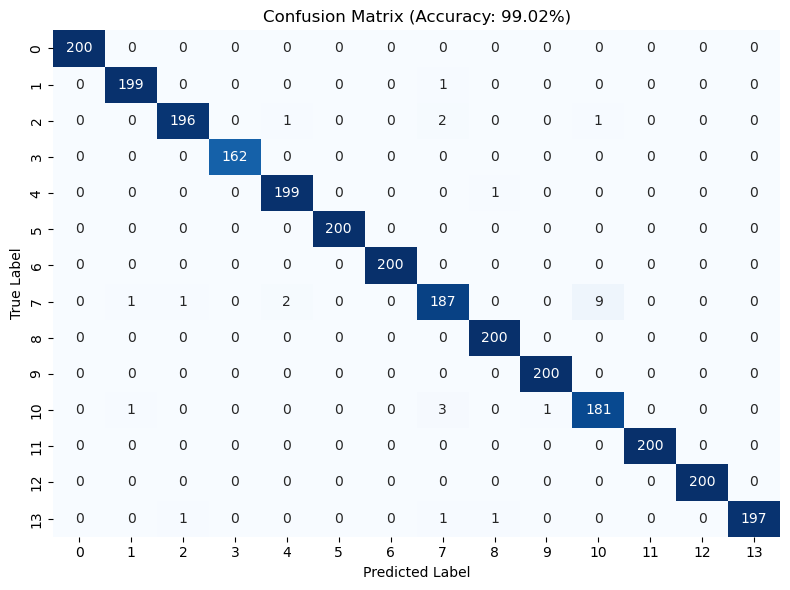

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

all_preds = []
all_labels = []
with torch.no_grad():
    for protein, label in test_loader:
        pred_class, probs, entropy = base_model.predict(protein)
        all_preds.append(pred_class.tolist())
        all_labels.append(label.tolist())

# Flatten predictions and labels
y_true = [lbl[0] if isinstance(lbl, list) else lbl for lbl in all_labels]
y_pred = [pred[0] if isinstance(pred, list) else pred for pred in all_preds]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=sorted(set(y_true)),
            yticklabels=sorted(set(y_true)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

In [43]:
import torch
from esm.sdk.api import ESMProtein, LogitsConfig

# Reconfigure encoder for token-level output
encoder.output = "tokens"
base_model.eval()

def compute_saliency(protein: ESMProtein, base_model, target_class: int = None):
    """
    Compute saliency map (gradient x input) over token embeddings for a given protein.
    """
    # Get token-level embeddings with gradients
    protein_tensor = base_model.encoder.client.encode(protein)
    protein_tensor.requires_grad = True

    logits_output = base_model.encoder.client.logits(
        protein_tensor,
        LogitsConfig(sequence=True, return_embeddings=True)
    ).embeddings  # shape: [1, seq_len, 960]

    token_embeddings = logits_output.clone().detach().requires_grad_(True)

    # Forward: average across sequence, then classify
    pooled_embedding = token_embeddings.mean(dim=1)  # shape: [1, 960]
    logits = base_model.classifier(pooled_embedding)

    # Target: use predicted class if none specified
    pred_class = torch.argmax(logits, dim=-1).item()
    target_class = target_class if target_class is not None else pred_class

    # Backward pass to compute gradients
    base_model.zero_grad()
    loss = logits[0, target_class]
    loss.backward()

    # Get gradients w.r.t. each token
    gradients = token_embeddings.grad.detach()  # shape: [1, seq_len, 960]

    # Compute saliency as ||grad * input|| per token
    saliency = (gradients * token_embeddings.detach()).norm(dim=-1).squeeze(0)  # shape: [seq_len]
    #saliency = saliency / saliency.sum() # Normalizing saliency to compare between proteins
    saliency = torch.softmax(saliency, dim=0)

    return saliency, pred_class

# Pick a protein to analyze
test_protein = ESMProtein(sequence="MKTLLLLAV")  # your sequence here
saliency, predicted_class = compute_saliency(test_protein, base_model)

100%|██████████| 2748/2748 [02:24<00:00, 19.06it/s]


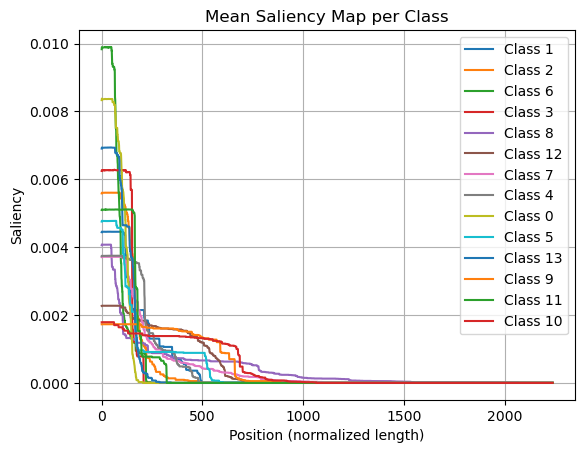

In [44]:
from collections import defaultdict
import torch

# Store saliency maps per class
saliency_per_class = defaultdict(list)
base_model.eval()
encoder.output = "tokens"

# Loop over proteins
for protein, label in tqdm(test_loader):
    with torch.no_grad():
        pred_class, _, _ = base_model.predict(protein)

    # Compute saliency for predicted class
    saliency, predicted_class = compute_saliency(protein, base_model, label)

    # Store saliency (as CPU tensor for simplicity)
    saliency_per_class[predicted_class].append(saliency.cpu())

# Optional: normalize all saliency maps to same length (e.g., 100 residues)
import torch.nn.functional as F

max_len = max(max(map(len, sals)) for sals in saliency_per_class.values())
mean_saliency_per_class = {}

for cls, sals in saliency_per_class.items():
    padded = [F.pad(sal, (0, max_len - len(sal))) for sal in sals]
    stacked = torch.stack(padded)
    mean_saliency_per_class[cls] = stacked.mean(dim=0)

# Plot example
import matplotlib.pyplot as plt

for cls, sal in mean_saliency_per_class.items():
    plt.plot(sal.numpy(), label=f"Class {cls}")

plt.title("Mean Saliency Map per Class")
plt.xlabel("Position (normalized length)")
plt.ylabel("Saliency")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
def last_nonzero_index(tensor: torch.Tensor, threshold: float = 0.00001) -> int:
    """
    Return the index of the last position where the saliency is greater than the threshold.
    Returns 0 if all values are <= threshold.
    """
    nonzero_indices = (tensor > threshold).nonzero(as_tuple=True)[0]
    return nonzero_indices.max().item() if len(nonzero_indices) > 0 else 0

# Compute "rightmost active position" for each class
class_last_index = {
    cls: last_nonzero_index(mean_saliency_per_class[cls])
    for cls in mean_saliency_per_class
}

# Sort classes by descending last index (most extended saliency first)
unique_classes = sorted(class_last_index, key=class_last_index.get, reverse=True)

In [55]:
max_length = class_last_index[max(class_last_index, key=class_last_index.get)]

/tmp/ipykernel_80429/665742288.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_classes))  # or 'tab20' for more classes


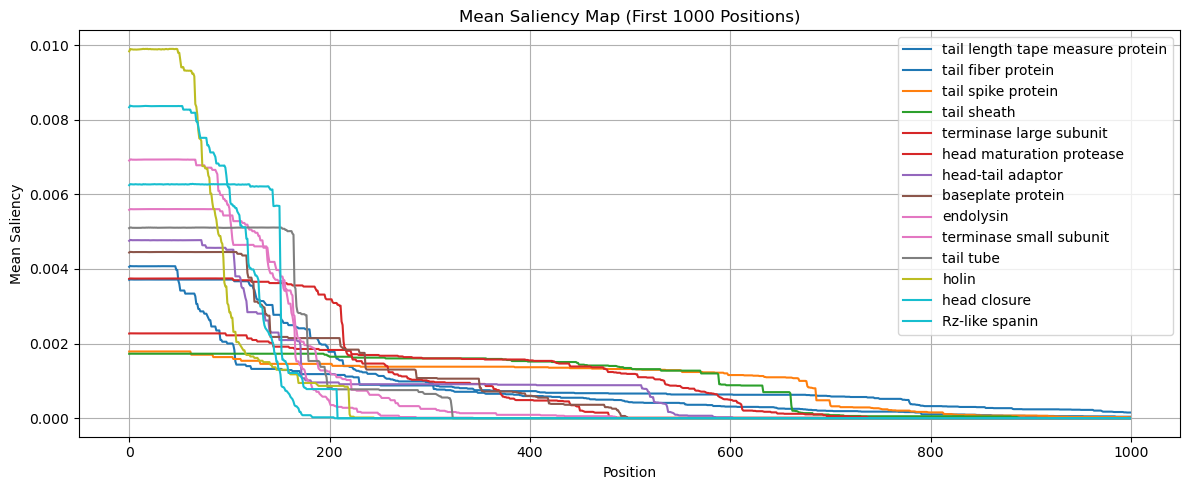

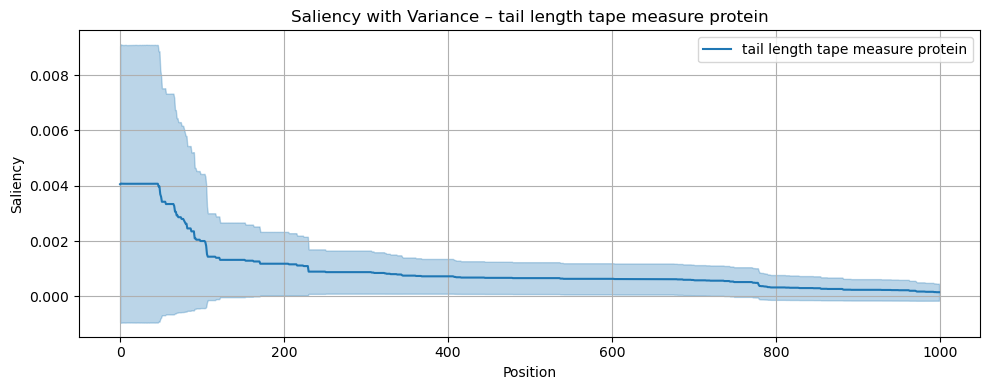

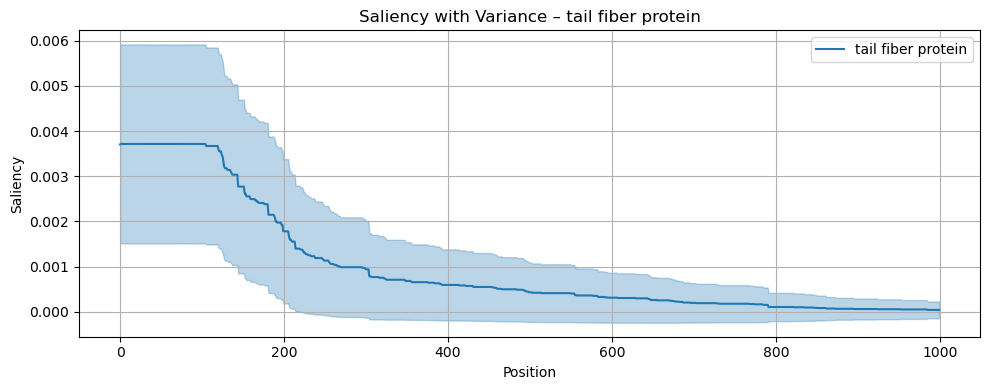

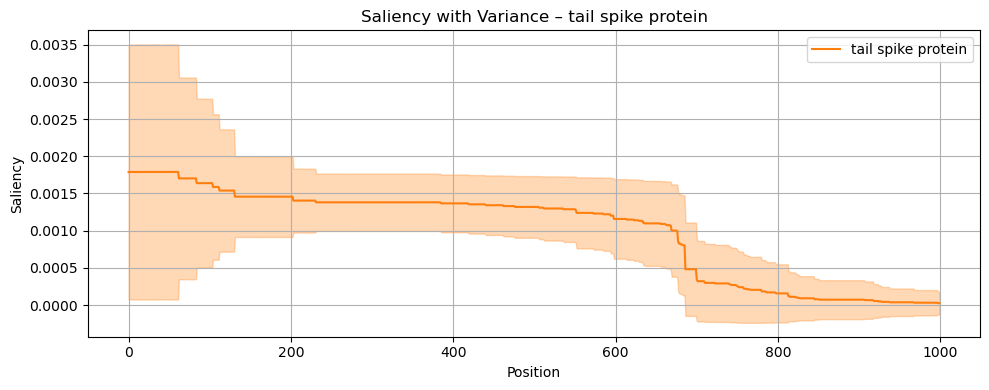

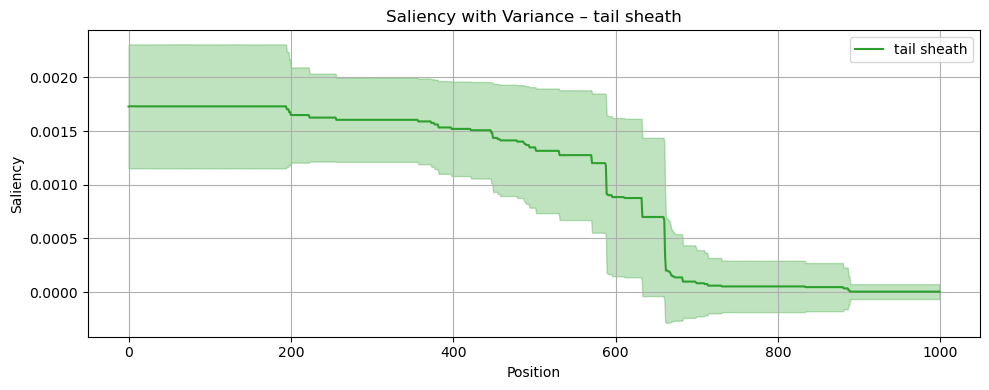

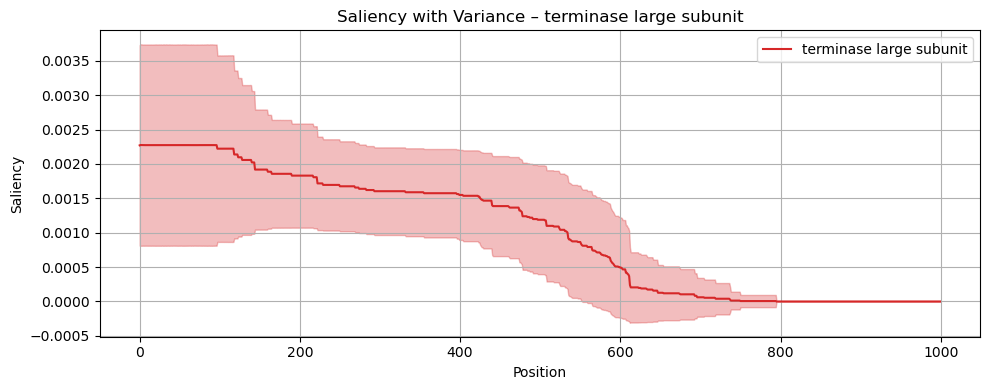

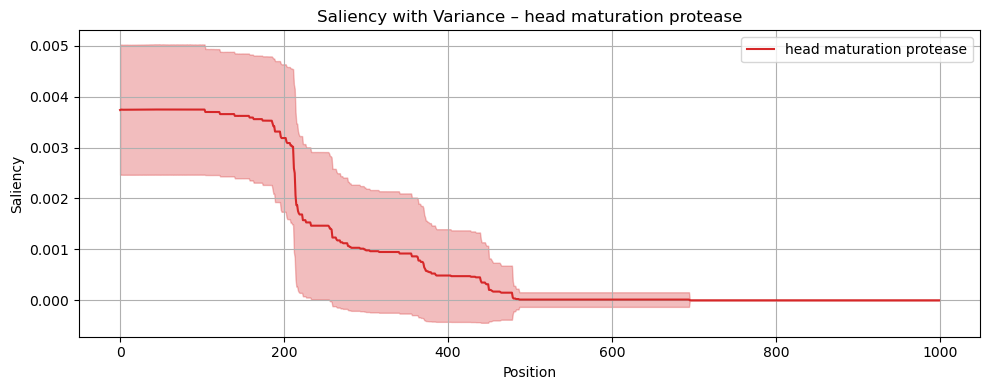

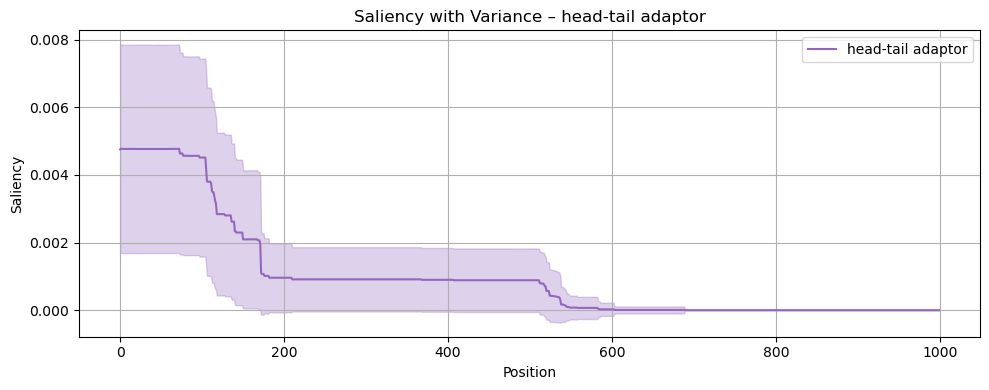

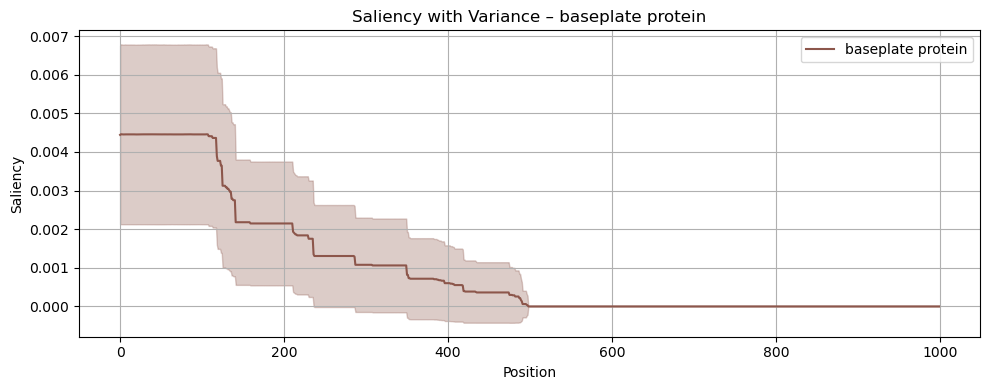

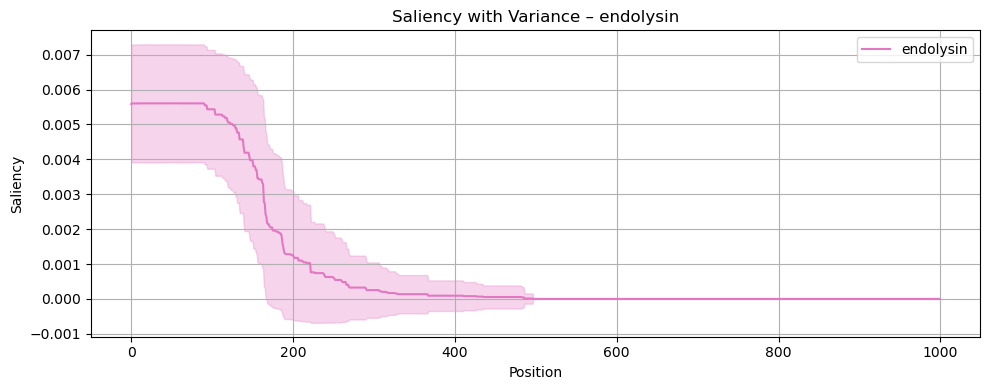

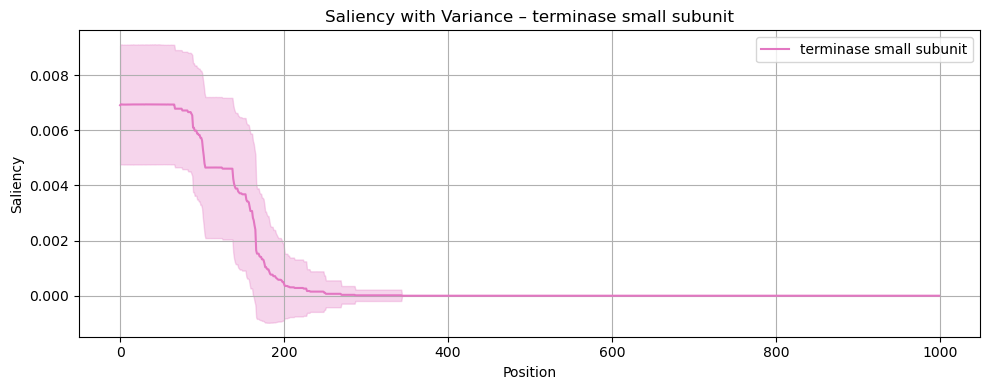

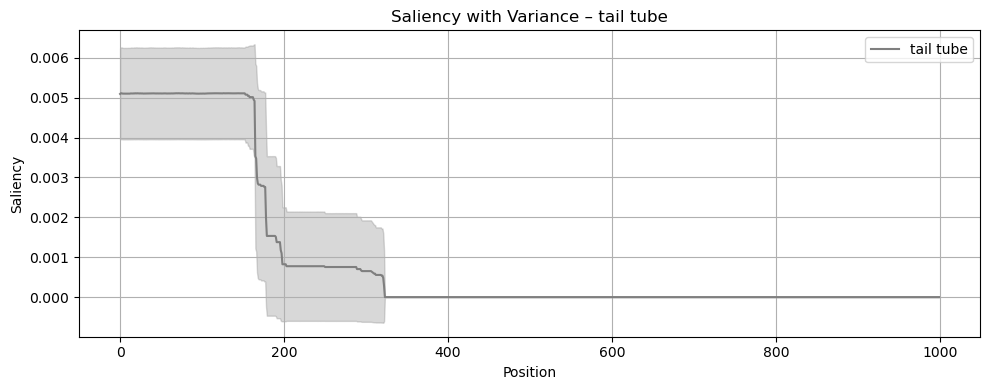

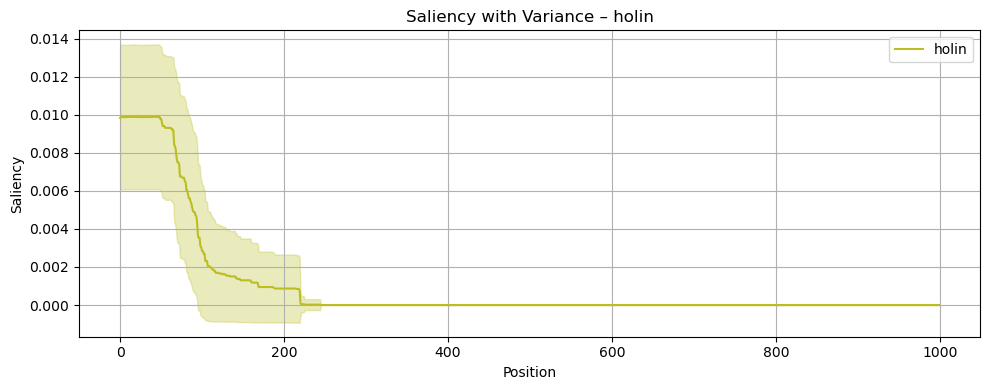

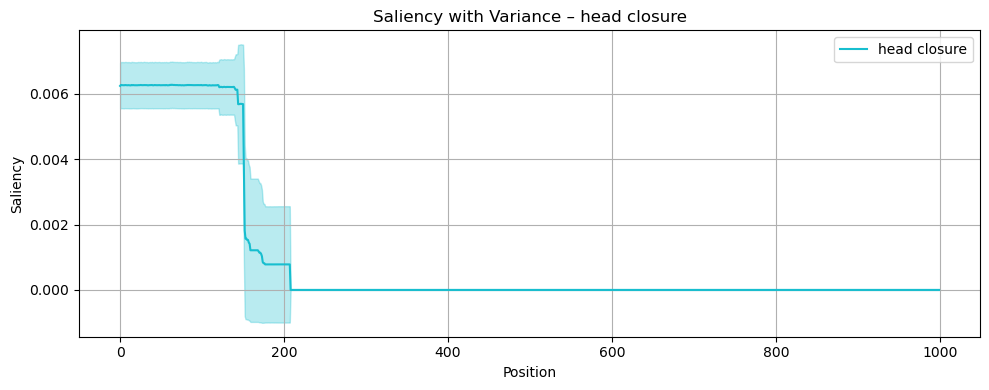

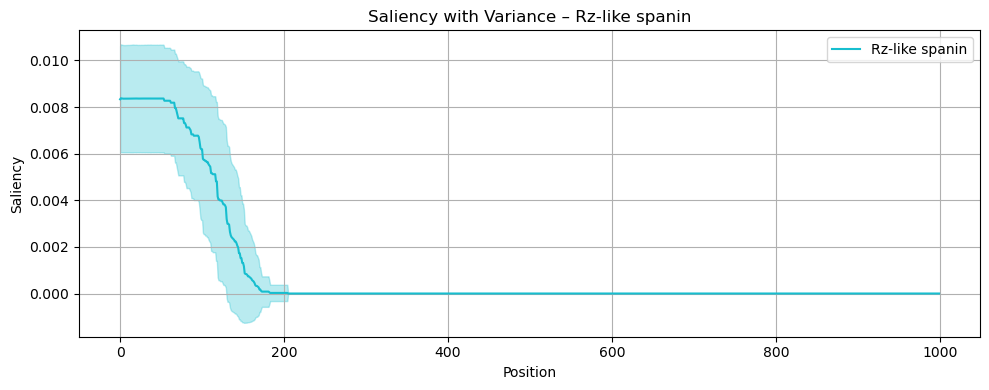

In [65]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Generate a fixed color map
#unique_classes = sorted(mean_saliency_per_class.keys())
cmap = cm.get_cmap("tab10", len(unique_classes))  # or 'tab20' for more classes

# Assign one color per class
class_colors = {cls: to_hex(cmap(i)) for i, cls in enumerate(unique_classes)}

# --- STEP 1: Compute padded mean and std per class ---
max_len = max(max(map(len, sals)) for sals in saliency_per_class.values())
clip_len = min(1000, max_len)  # Limit to first 1000 positions

mean_saliency_per_class = {}
std_saliency_per_class = {}

for cls, sals in saliency_per_class.items():
    padded = [F.pad(sal, (0, max_len - len(sal))) for sal in sals]
    stacked = torch.stack(padded)[:, :clip_len]  # Trim to 1000 positions
    mean_saliency_per_class[cls] = stacked.mean(dim=0)#  * (class_last_index[cls] / max_length)
    std_saliency_per_class[cls] = stacked.std(dim=0)# * (class_last_index[cls] / max_length)


# --- STEP 2: Combined line plot for all classes ---
plt.figure(figsize=(12, 5))
for cls in unique_classes:
    label = label_to_hr.get(cls, f"Class {cls}")
    color = class_colors[cls]
    plt.plot(mean_saliency_per_class[cls].numpy(), label=label, color=color)

plt.title("Mean Saliency Map (First 1000 Positions)")
plt.xlabel("Position")
plt.ylabel("Mean Saliency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for cls in unique_classes:
    label = label_to_hr.get(cls, f"Class {cls}")
    mean_sal = mean_saliency_per_class[cls].numpy()
    std_sal = std_saliency_per_class[cls].numpy()
    positions = np.arange(len(mean_sal))
    color = class_colors[cls]

    plt.figure(figsize=(10, 4))
    plt.plot(positions, mean_sal, label=label, color=color)
    plt.fill_between(positions, mean_sal - std_sal, mean_sal + std_sal, alpha=0.3, color=color)
    plt.title(f"Saliency with Variance – {label}")
    plt.xlabel("Position")
    plt.ylabel("Saliency")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_80429/2397833264.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_classes))  # or 'tab20' for more classes


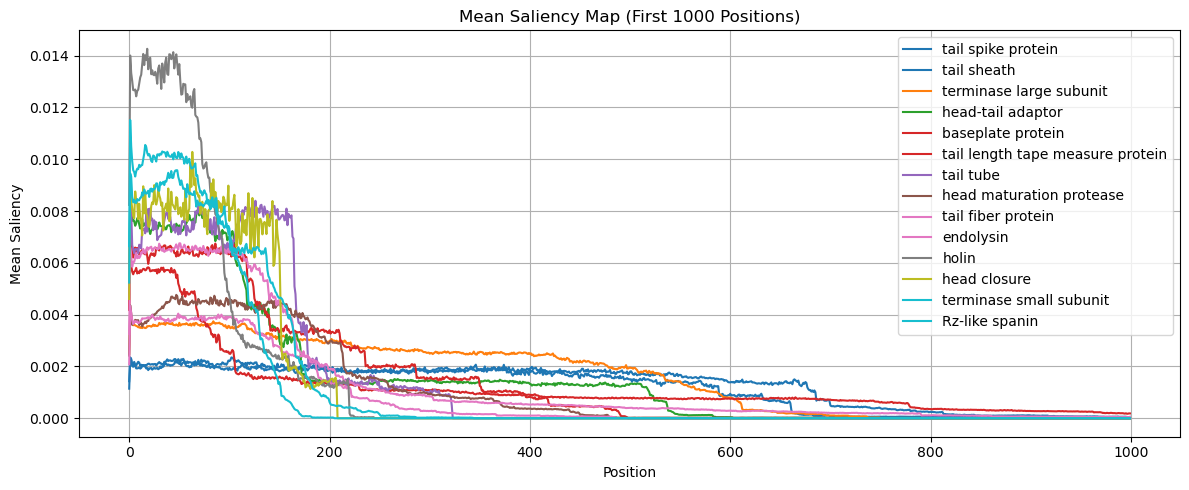

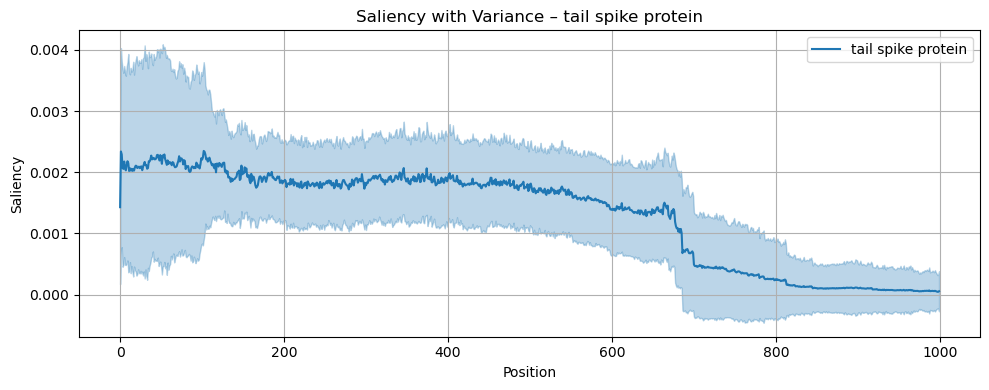

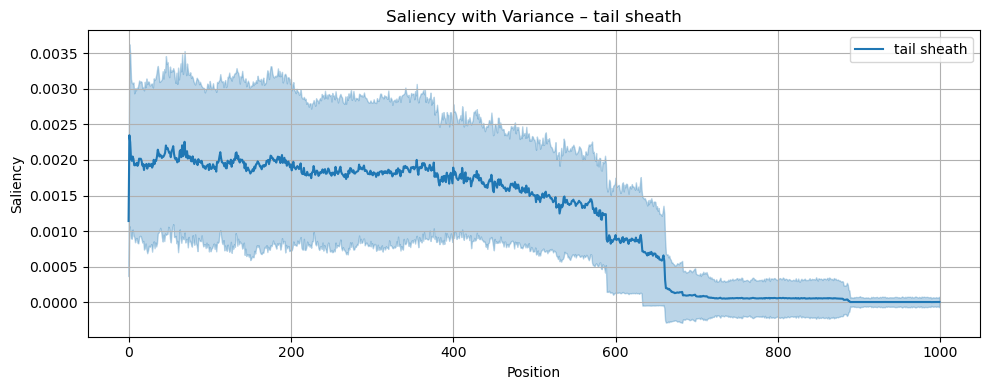

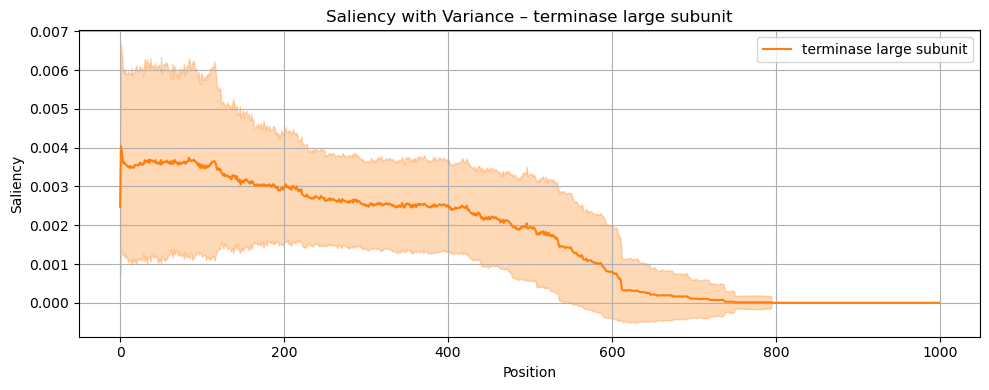

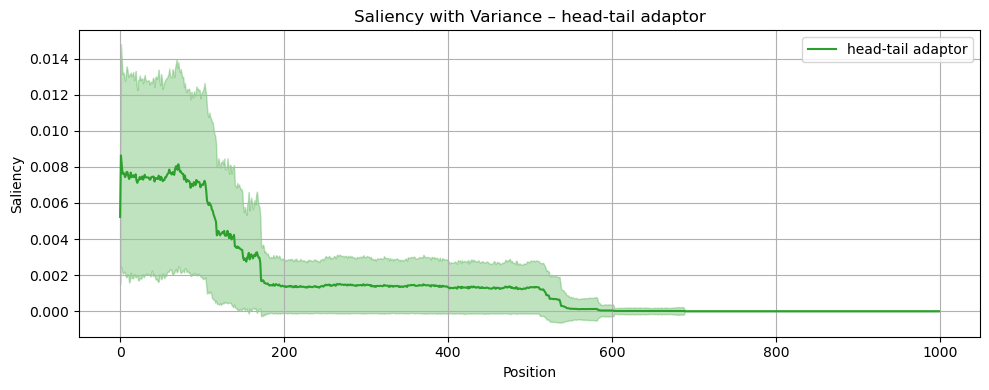

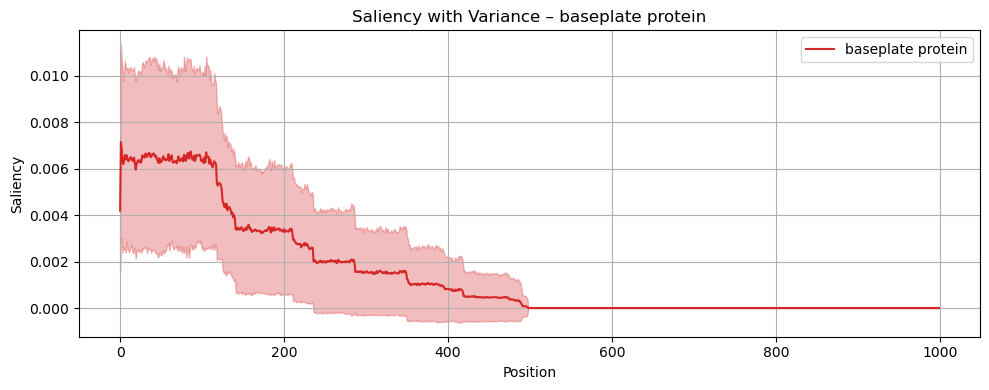

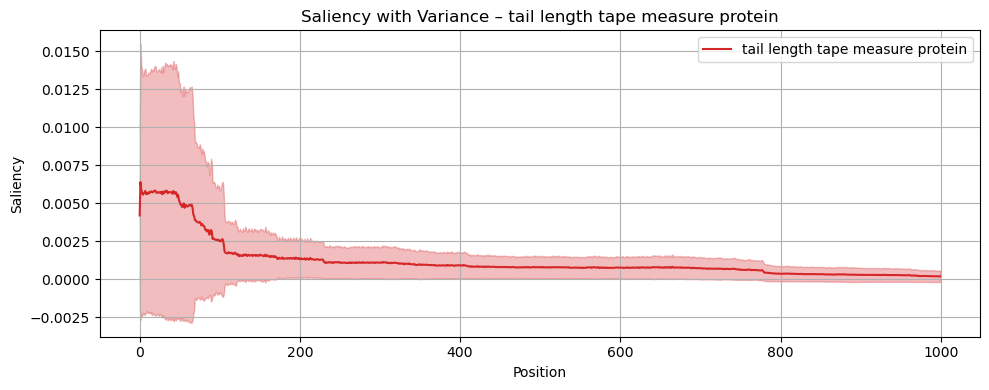

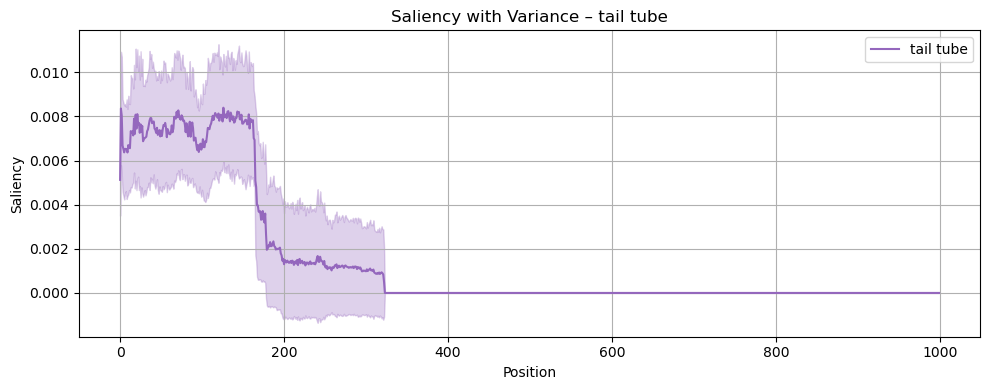

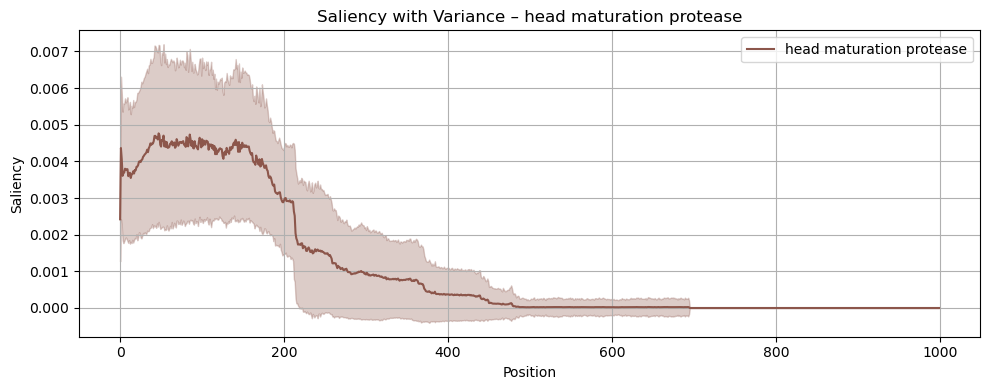

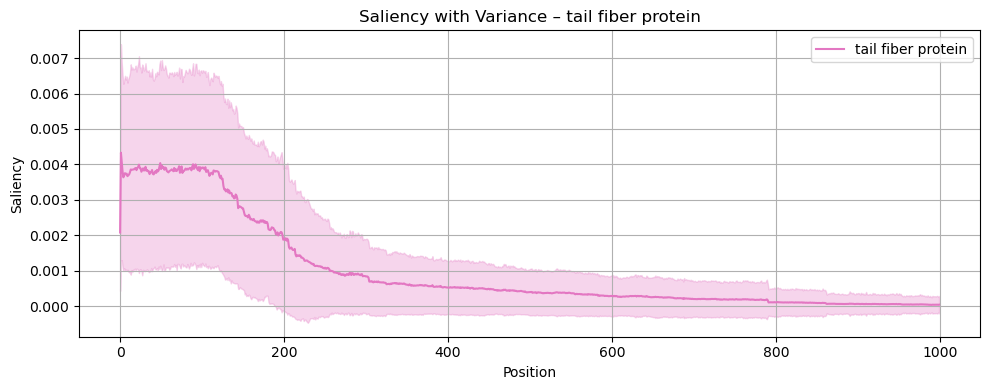

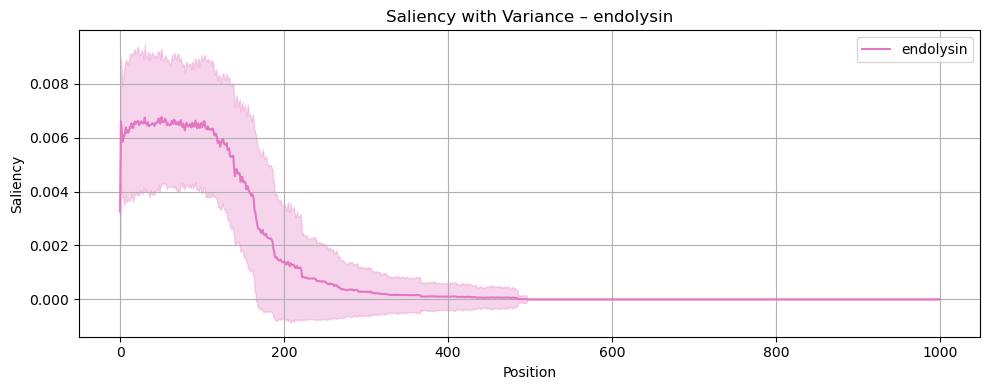

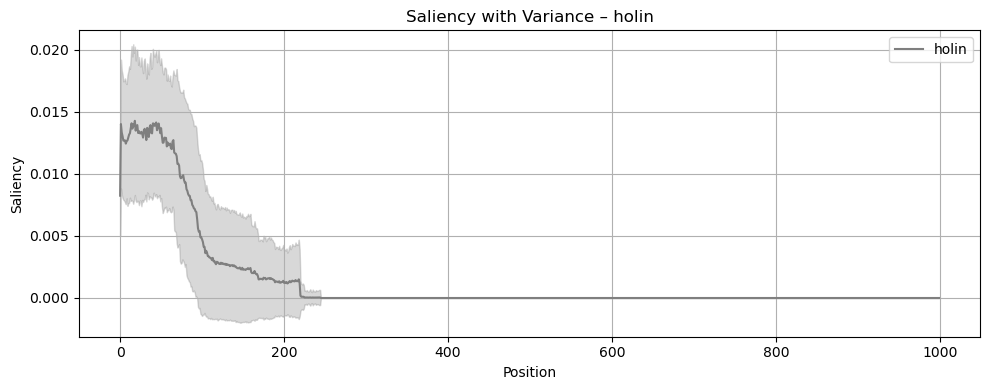

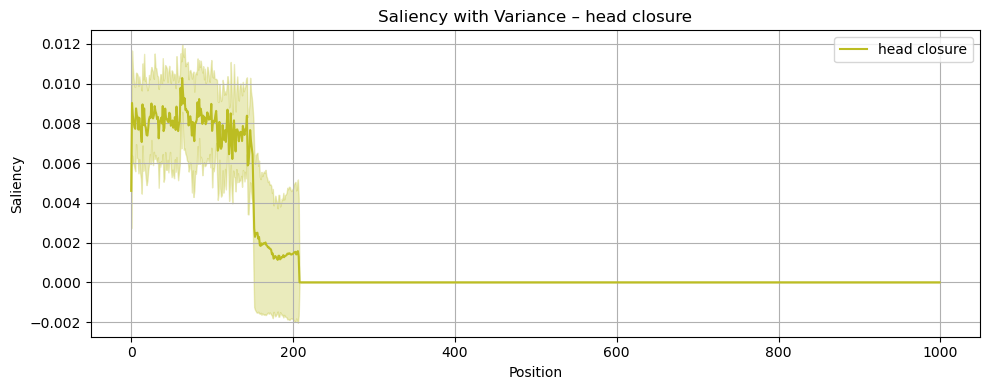

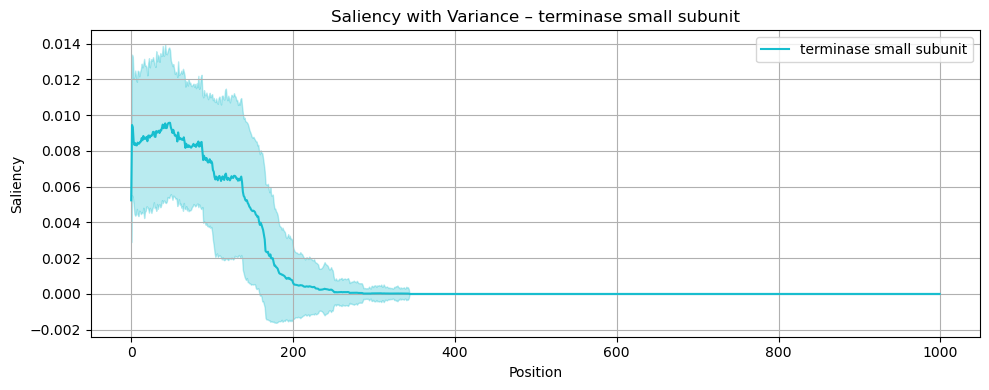

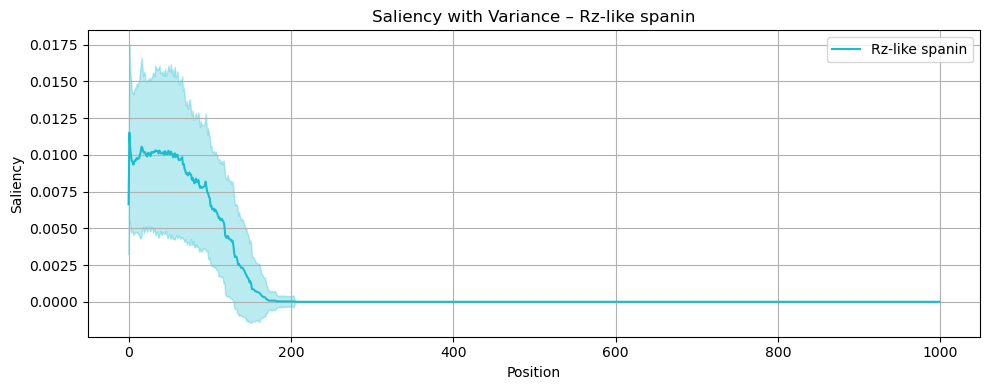

In [39]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Generate a fixed color map
#unique_classes = sorted(mean_saliency_per_class.keys())
cmap = cm.get_cmap("tab10", len(unique_classes))  # or 'tab20' for more classes

# Assign one color per class
class_colors = {cls: to_hex(cmap(i)) for i, cls in enumerate(unique_classes)}

# --- STEP 1: Compute padded mean and std per class ---
max_len = max(max(map(len, sals)) for sals in saliency_per_class.values())
clip_len = min(1000, max_len)  # Limit to first 1000 positions

mean_saliency_per_class = {}
std_saliency_per_class = {}

for cls, sals in saliency_per_class.items():
    padded = [F.pad(sal, (0, max_len - len(sal))) for sal in sals]
    stacked = torch.stack(padded)[:, :clip_len]  # Trim to 1000 positions
    mean_saliency_per_class[cls] = stacked.mean(dim=0)
    std_saliency_per_class[cls] = stacked.std(dim=0)


# --- STEP 2: Combined line plot for all classes ---
plt.figure(figsize=(12, 5))
for cls in unique_classes:
    label = label_to_hr.get(cls, f"Class {cls}")
    color = class_colors[cls]
    plt.plot(mean_saliency_per_class[cls].numpy(), label=label, color=color)

plt.title("Mean Saliency Map (First 1000 Positions)")
plt.xlabel("Position")
plt.ylabel("Mean Saliency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for cls in unique_classes:
    label = label_to_hr.get(cls, f"Class {cls}")
    mean_sal = mean_saliency_per_class[cls].numpy()
    std_sal = std_saliency_per_class[cls].numpy()
    positions = np.arange(len(mean_sal))
    color = class_colors[cls]

    plt.figure(figsize=(10, 4))
    plt.plot(positions, mean_sal, label=label, color=color)
    plt.fill_between(positions, mean_sal - std_sal, mean_sal + std_sal, alpha=0.3, color=color)
    plt.title(f"Saliency with Variance – {label}")
    plt.xlabel("Position")
    plt.ylabel("Saliency")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

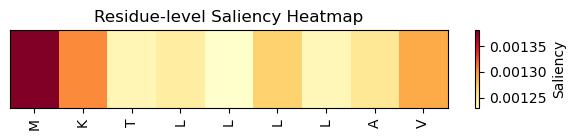

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_saliency(protein: ESMProtein, saliency):
    aa_seq = list(protein.sequence)
    
    # Remove CLS and EOS tokens
    saliency_values = saliency.detach().cpu().tolist()[1:-1]
    
    # Create a 2D heatmap shape: [1, sequence_length]
    saliency_array = np.array(saliency_values).reshape(1, -1)

    plt.figure(figsize=(max(len(aa_seq) * 0.3, 6), 1.5))
    plt.imshow(saliency_array, cmap="YlOrRd", aspect="auto")

    plt.xticks(ticks=range(len(aa_seq)), labels=aa_seq, rotation=90)
    plt.yticks([])  # Hide y-axis
    plt.colorbar(label="Saliency")
    plt.title("Residue-level Saliency Heatmap")
    plt.tight_layout()
    plt.show()

plot_saliency(test_protein, saliency)